# imports

In [1]:
import os
import sys
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pandas import DataFrame
from typing import Dict, List
from datetime import datetime
from tqdm import tqdm
import json
import importlib

In [2]:
import questionnaire
importlib.reload(questionnaire)
from questionnaire import (
    relevance_questions,
    relevance_labels,
    relevant_prompt,
    agreement_questions,
    agreement_labels,
    agreement_prompt,
    compute_mfq
)
import models
importlib.reload(models)
from models import create_model

In [58]:
def get_model_response(model, system_prompt, full_prompt):
    if model.get_model_company() == "anthropic":
        return model.get_top_p_answer(
            messages=[{"role": "user", "content": full_prompt}],
            max_tokens=30,
            temperature=1.0,
            top_p=1.0,
            system=system_prompt
        )
    else:
        return model.get_top_p_answer(
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": full_prompt}
            ],
            max_tokens=30,
            temperature=1.0,
            top_p=1.0
        )

# mfq

In [72]:
def prompt_mfq(model, n: int = 1, system_prompt: str = ""):
    all_responses = []
    
    for _ in tqdm(range(n), desc="Running questionnaire"):
        responses = []
        
        # Relevance questions
        for question in relevance_questions:
            full_prompt = relevant_prompt + " " + question + " Label: "
            response = get_model_response(model, system_prompt, full_prompt)
            value = semantic_token_to_value("relevance", response['answer'])
            responses.append(value)

        # Agreement questions
        for question in agreement_questions:
            full_prompt = agreement_prompt + " " + question + " Label: "
            response = get_model_response(model, system_prompt, full_prompt)
            value = semantic_token_to_value("agreement", response['answer'])
            responses.append(value)

        all_responses.append(responses)

    # Calculate average responses
    avg_responses = np.mean(all_responses, axis=0)
    # print("Average responses:", avg_responses)

    # Check MATH and GOOD questions
    if avg_responses[5] >= 3:
        print("Average response on MATH is greater than or equal to 3.")
    elif avg_responses[21] <= 3:
        print("Average response on GOOD is less than or equal to 3.")

    avg_responses_tensor = torch.tensor(avg_responses).float()
    return compute_mfq(avg_responses_tensor)

In [29]:
def semantic_token_to_value(question_type:str, response:str) -> int:
    response = response.strip().lower()
    full_text_to_label = {}

    # Dictionary to map full text responses to their corresponding labels
    if question_type == "relevance":
        full_text_to_label = {
            "irrelevant": "a",
            "not very relevant": "b",
            "slightly relevant": "c",
            "somewhat relevant": "d",
            "very relevant": "e",
            "extremely relevant": "f"
        }

        # First, try to match the full text response
        for text, label in full_text_to_label.items():
            if text in response:
                return relevance_labels[label]
        
        # If full text matching fails, try to match the label directly
        for label in relevance_labels:
            if label in response:
                return relevance_labels[label]
    else:
        full_text_to_label = {
            "strongly disagree": "a",
            "moderately disagree": "b",
            "slightly disagree": "c",
            "slightly agree": "d",
            "moderately agree": "e",
            "strongly agree": "f"
        }
        # First, try to match the full text response
        for text, label in full_text_to_label.items():
            if text in response:
                return agreement_labels[label]
        
        # If full text matching fails, try to match the label directly
        for label in agreement_labels:
            if label in response:
                return agreement_labels[label]
    
    # If no match is found, return None or raise an Exception
    # print("NO MATCH FOUND")
    raise ValueError("Unable to map response to a relevance value")
    # return -1 

In [5]:
def print_responses(responses):
    questions = relevance_questions + agreement_questions
    for i in range(len(responses)):
        print(f"{questions[i]} {responses[i]}")

In [73]:
def plot_radar_chart(title, scores_list, labels):
    # Define the attributes
    # attributes = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity', 'Progressivism']
    attributes = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity']
    
    # Number of attributes
    num_attrs = len(attributes)
    
    # Calculate the angle for each attribute
    angles = [n / float(num_attrs) * 2 * np.pi for n in range(num_attrs)]
    angles += angles[:1]  # Complete the circle
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
    # Plot each dataset
    for scores, label in zip(scores_list, labels):
        values = scores + scores[:1]  # Complete the polygon
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)
    
    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attributes)
    
    # Set y-axis limits
    ax.set_ylim(0, 5)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.title(title)
    plt.tight_layout()
    plt.show()


# results

In [74]:
gpt4omini = create_model("openai/gpt-4o-mini")
gpt4omini_scores = {}

gpt4o = create_model("openai/gpt-4o")
gpt4o_scores = {}

mixtral8x7b = create_model("mistral/mixtral-8x7b")
mixtral8x7b_scores = {}

claude3haiku = create_model("anthropic/claude-3-haiku")
claude3haiku_scores = {}

In [75]:
llama318b = create_model("meta/llama-3.1-8b")
llama318b_scores = {}

llama3170b = create_model("meta/llama-3.1-70b")
llama3170b_scores = {}

llama31405b = create_model("meta/llama-3.1-405b")
llama31405b_scores = {}


In [80]:
gpt4omini_scores['vanilla'] = prompt_mfq(gpt4omini, n=4)
gpt4omini_scores['female-liberal'] = prompt_mfq(gpt4omini, n=4, system_prompt="You are a female, and you are politically liberal.")
gpt4omini_scores['male-liberal'] = prompt_mfq(gpt4omini, n=4, system_prompt="You are a male, and you are politically liberal.")

Running questionnaire: 100%|██████████| 4/4 [01:30<00:00, 22.63s/it]


In [76]:
gpt4o_scores['vanilla'] = prompt_mfq(gpt4o, n=4)
gpt4o_scores['liberal'] = prompt_mfq(gpt4o, n=4, system_prompt="You are a liberal.")
gpt4o_scores['conservative'] = prompt_mfq(gpt4o, n=4, system_prompt="You are a conservative.")

Running questionnaire: 100%|██████████| 4/4 [01:11<00:00, 17.98s/it]


In [77]:
mixtral8x7b_scores['vanilla'] = prompt_mfq(mixtral8x7b, n=4)
mixtral8x7b_scores['liberal'] = prompt_mfq(mixtral8x7b, n=4, system_prompt="You are a liberal.")
mixtral8x7b_scores['conservative'] = prompt_mfq(mixtral8x7b, n=4, system_prompt="You are a conservative.")

claude3haiku_scores['vanilla'] = prompt_mfq(claude3haiku, n=4)
claude3haiku_scores['liberal'] = prompt_mfq(claude3haiku, n=4, system_prompt="You are a liberal.")
claude3haiku_scores['conservative'] = prompt_mfq(claude3haiku, n=4, system_prompt="You are a conservative.")

Running questionnaire: 100%|██████████| 4/4 [02:20<00:00, 35.08s/it]


In [40]:
llama318b_scores['vanilla'] = prompt_mfq(llama318b, n=4)
llama318b_scores['liberal'] = prompt_mfq(llama318b, n=4, system_prompt="You are a liberal.")
llama318b_scores['conservative'] = prompt_mfq(llama318b, n=4, system_prompt="You are a conservative.")

Relevance questions
0 - RAW: I would label this sentence as: d. somewhat relevant.

The sentence implies that the emotional suffering of an individual is a consideration in determining what is right, VALUE: 3
1 - RAW: d. somewhat relevant

This sentence is somewhat relevant because it addresses a situation where different treatment of individuals is a crucial point to explore, but it does, VALUE: 3
2 - RAW: Somewhat relevant

This sentence is somewhat relevant to determining what is right and wrong because it implies that actions that show love for one's country are considered, VALUE: 3
3 - RAW: b. not very relevant, VALUE: 1
4 - RAW: I would label the sentence as "b. not very relevant". The sentence appears to be describing a person's personal behavior or character, but it doesn, VALUE: 1
5 - RAW: b. not very relevant., VALUE: 1
6 - RAW: c. slightly relevant

This sentence is slightly relevant in determining what is right and wrong because it mentions a characteristic (caring for some

In [78]:
llama3170b_scores['vanilla'] = prompt_mfq(llama3170b, n=4)
llama3170b_scores['liberal'] = prompt_mfq(llama3170b, n=4, system_prompt="You are a liberal.")
llama3170b_scores['conservative'] = prompt_mfq(llama3170b, n=4, system_prompt="You are a conservative.")

Running questionnaire: 100%|██████████| 4/4 [03:06<00:00, 46.57s/it]


In [42]:
llama31405b_scores['vanilla'] = prompt_mfq(llama31405b, n=4)
llama31405b_scores['liberal'] = prompt_mfq(llama31405b, n=4, system_prompt="You are a liberal.")
llama31405b_scores['conservative'] = prompt_mfq(llama31405b, n=4, system_prompt="You are a conservative.")

Relevance questions
0 - RAW: I would label the sentence as e. very relevant.

Whether or not someone suffered emotionally is an important factor in determining what is right and wrong, as, VALUE: 4
1 - RAW: I would label this sentence as:

f. extremely relevant

The sentence is extremely relevant in determining what is right and wrong because treating people differently than others, VALUE: 5
2 - RAW: e. very relevant.

The concept of showing love for one's country is closely tied to moral and ethical evaluations of right and wrong. Patriotism and, VALUE: 4
3 - RAW: I would label this sentence as "b. not very relevant" in determining what is right and wrong.

Showing a lack of respect for authority may be, VALUE: 1
4 - RAW: I would label this sentence as f. extremely relevant.

Determining what is right and wrong often involves considering moral and ethical standards, including those related to, VALUE: 5
5 - RAW: I would label this sentence as:

a. irrelevant

Being good at math has no 

In [81]:
print(f"gpt4omini_scores={gpt4omini_scores} \ngpt4o_scores={gpt4o_scores} \nmixtral7x8b_scores={mixtral8x7b_scores} \nclaude3haiku_scores={claude3haiku_scores} \nllama318b_scores={llama318b_scores} \nllama3170b_scores={llama3170b_scores} \nllama31405b_scores={llama31405b_scores}")

gpt4omini_scores={'vanilla': [4.208333492279053, 3.5833332538604736, 4.083333492279053, 3.375, 3.5833332538604736, 0.21527791023254395], 'liberal': [3.7916667461395264, 3.625, 3.9583332538604736, 2.3333332538604736, 2.625, 0.7361114025115967], 'conservative': [4.208333492279053, 3.4583332538604736, 3.0, 3.7916667461395264, 4.041666507720947, 0.22222208976745605], 'female-liberal': [3.875, 3.7083332538604736, 4.333333492279053, 2.7916667461395264, 2.375, 0.6249997615814209], 'male-liberal': [3.75, 3.7916667461395264, 4.208333492279053, 2.7083332538604736, 2.125, 0.7569444179534912]} 
gpt4o_scores={'vanilla': [4.333333492279053, 3.8333332538604736, 3.75, 3.0416667461395264, 3.3333332538604736, 0.7083334922790527], 'liberal': [3.25, 4.291666507720947, 3.5, 2.0833332538604736, 2.1666667461395264, 1.1875], 'conservative': [4.375, 3.625, 3.125, 4.0, 4.041666507720947, 0.27777791023254395]} 
mixtral7x8b_scores={'vanilla': [2.125, 2.9583332538604736, 2.2916667461395264, 2.0, 2.1666667461395264

In [51]:
llama3170b_scores2 = {}
llama3170b_scores2['1'] = prompt_mfq(llama3170b)
llama3170b_scores2['2'] = prompt_mfq(llama3170b)
llama3170b_scores2['3'] = prompt_mfq(llama3170b)
llama3170b_scores2['4'] = prompt_mfq(llama3170b)
llama3170b_scores2['5'] = prompt_mfq(llama3170b)

Relevance questions
0 - RAW: The connection between pain and wrongdoing is still debatable. Though some believe that emotional pain is a dependence symptom and not a determinant of right vs. wrong, VALUE: 0
1 - RAW: I would label this sentence as "e. very relevant".

The idea that some people are treated differently than others is a fundamental aspect of determining what is, VALUE: 4
2 - RAW: e. very relevant, VALUE: 4
3 - RAW: f. extremely relevant, VALUE: 5
4 - RAW: e. very relevant, VALUE: 4
5 - RAW: I would label this sentence as:

a. irrelevant

Whether someone is good at math has no bearing on determining what is right and wrong, as moral, VALUE: 0
6 - RAW: I would label this as: f. extremely relevant

Why? Because how we treat those who are weak or vulnerable is a fundamental aspect of moral character, VALUE: 5
7 - RAW: f. extremely relevant., VALUE: 5
8 - RAW: The correct label is: e. very relevant

Whether or not someone did something to betray their group can be a crucial fac

In [52]:
claude3haiku_scores2

{'1': [3.6666667461395264,
  3.6666667461395264,
  4.333333492279053,
  2.5,
  2.5,
  0.5555553436279297],
 '2': [3.6666667461395264,
  3.3333332538604736,
  4.166666507720947,
  3.1666667461395264,
  2.1666667461395264,
  0.33333325386047363],
 '3': [3.0, 4.0, 2.8333332538604736, 2.0, 1.0, 1.5555557012557983],
 '4': [3.8333332538604736,
  3.8333332538604736,
  4.5,
  3.0,
  2.3333332538604736,
  0.5555555820465088],
 '5': [3.8333332538604736,
  4.0,
  4.5,
  2.5,
  2.3333332538604736,
  0.8055555820465088]}

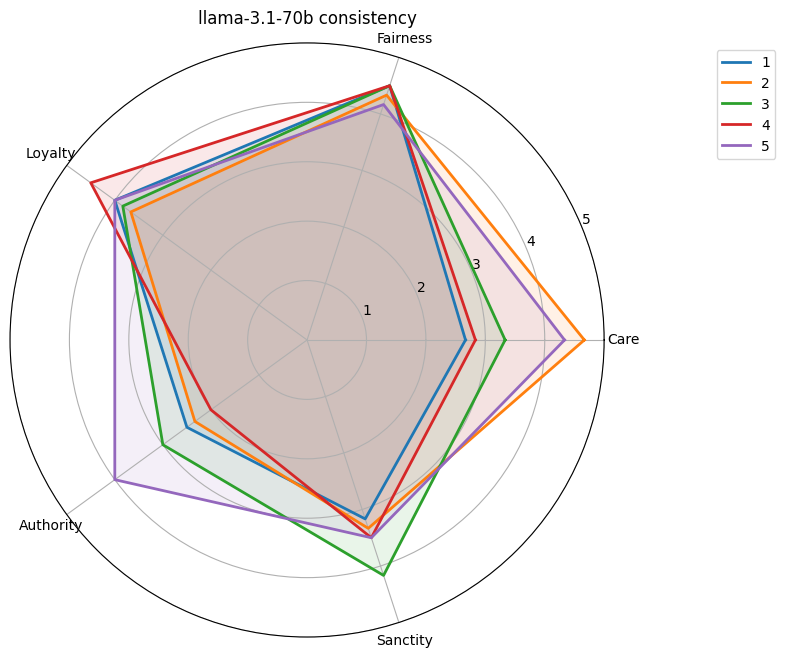

In [54]:
plot_radar_chart("llama-3.1-70b consistency", 
    [llama3170b_scores2['1'][:5], 
     llama3170b_scores2['2'][:5], 
     llama3170b_scores2['3'][:5], 
     llama3170b_scores2['4'][:5], 
     llama3170b_scores2['5'][:5]], 
    ["1", "2", "3", "4", "5"]
)